In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

# Funzioni utili

In [53]:
def dms_to_dd(d, m, s):
    dd = d + float(m)/60 + float(s)/3600
    return dd

def Minima_dev_prisma(deg, alfa, deg_err, alfa_err):
    '''
    Calcola n dato l'angolo di incidenza e l'angolo di deviazione, e calcola l'errore
    '''
    x = np.sin(np.radians(deg + alfa)/2) / np.sin(np.radians(alfa/2))

    rad = np.radians(deg)
    alfa_rad = np.radians(alfa)
    rad_err = np.radians(deg_err)
    alfa_rad_err = np.radians(alfa_err)

    y = (np.sqrt((np.sin(alfa_rad/2)*np.cos((alfa_rad+rad)/2)*rad_err)**2+(np.sin(rad/2)*alfa_rad_err)**2))/np.abs(np.cos(alfa_rad)-1)
    
    return x, y

def Cauchy_ignoto(n, a, b, n_err, a_err, b_err, cov_ab):
    '''
    Calcola il valore di lambda e il suo errore
    '''
    x = np.sqrt(b/(n-a))
    y = np.sqrt(b*(a_err/(2*(n-a)))**2 + (b_err/2)**2/b + b*(n_err/(2*(n-a)))**2 + cov_ab/2)/(np.sqrt(n-a))

    return x, y

def Cauchy(x, a, b):
    return a + (b) / (x**2)

def d_reticolo(n, lambda_, theta, sigma_theta):
    sigma_theta = np.radians(sigma_theta)
    x = n*lambda_/(np.sin(np.radians(theta)))
    y = abs(n*lambda_*np.cos(np.radians(theta))*sigma_theta/(np.sin(np.radians(theta)))**2)
    return x, y

def lambda_reticolo(n, d, theta, sigma_theta):
    sigma_theta = np.radians(sigma_theta)
    x = d*np.sin(np.radians(theta))/n
    y = abs(d*np.cos(np.radians(theta))*sigma_theta/n)
    return x, y

# CARATTERIZZAZIONE DEL PRISMA

## Mercurio
Incertezza/scala ver = 1' \
primo angolo riflesso = 285° 11' \
secondo angolo riflesso = 166° 6' \
alfa = 60 °

In [54]:
angolo_minimo_prisma = pd.read_excel("PrismaAngoloMinimo.xlsx")

# lista dei colori
colori_1 = ["giallo", "ciano", "blu", "viola"]

# matrici delle misure - colonna ciano modificata(9)
deg_mat_prisma = angolo_minimo_prisma.iloc[:, [0, 2, 4, 6]].values.T
primi_mat_prisma = angolo_minimo_prisma.iloc[:, [1, 9, 5, 7]].values.T

# calcolo delle medie e degli errori
deg_prisma = []
err_prisma = []
for i in range(4):
    deg = []
    for j in range(len(deg_mat_prisma[i])):
        deg.append(dms_to_dd(deg_mat_prisma[i][j], primi_mat_prisma[i][j], 0))
    deg_prisma.append(np.mean(deg))
    err_prisma.append(np.std(deg, ddof=1)/np.sqrt(len(deg)))

for i in range(len(colori_1)):
    print(f"Angolo minimo per il {colori_1[i]}: {deg_prisma[i]:.4g} ± {err_prisma[i]:.1g}")

Angolo minimo per il giallo: 48.05 ± 0.01
Angolo minimo per il ciano: 49.55 ± 0.009
Angolo minimo per il blu: 50.11 ± 0.01
Angolo minimo per il viola: 51.01 ± 0.004


In [55]:
err_prisma = [1/60]*4

Penso che le misure dei primi siano sbagliate...\
Per correggere dovrebbe bastare aggiungere 30 primi a ciano \
L'ho implementato nel codice aggiungendo una colonna, per usare i valori originali mettere 3 al posto di 9

In [56]:
# interpolazione di Cauchy

alfa = 60
lambda_note = [579.0663e-9, 435.8328e-9, 404.6563e-9, 365.0153e-9]

n_prisma, n_prisma_err = zip(*[Minima_dev_prisma(deg_prisma[i], alfa, err_prisma[i], 0) for i in range(4)])

pars1, vals1, ers1, *other1 = LS_fit(lambda_note, n_prisma, n_prisma_err, Cauchy, a = 1, b = 1)
cov1 = other1[-1][0][1] # covarianza tra a e b

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.004 (χ²/ndof = 1.0)      │              Nfcn = 99               │
│ EDM = 1.04e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │  1.59890  │  0.00029  │            │            │         │         │       │
│ 1 │ b    │ 6.61e-15  │ 0.05e-15  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────────────────┐
│   │                     a                     b │
├───┼─────────────────────────────────────────────┤
│ a │              8.67e-08 -14.4755996561103e-21 │
│ b │ -14.4755996561103e-21              2.63e-33 │
└───┴─────────────────────────────────────────────┘

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
C:\Users\franc\AppData\Local\Temp\ipykernel_3644\1157388818.py:7: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$ [m]")


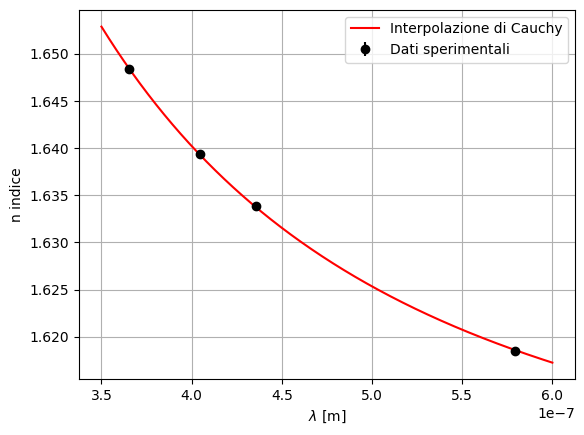

In [57]:
#Plot del grafico da inserire nella relazione

x = np.linspace(0.35e-6, 0.6e-6, 1000)

plt.errorbar(lambda_note, n_prisma, yerr = n_prisma_err, fmt = "o", color = "black", label = "Dati sperimentali")
plt.plot(x, Cauchy(x, *vals1), color = "red", label = "Interpolazione di Cauchy")
plt.xlabel("$\lambda$ [m]")
plt.ylabel("n indice")
plt.legend()
plt.grid()
plt.show()

## Gas ignoto
Sottrarre angoli di 180° 

In [58]:
gas_ignoto = pd.read_excel("GasIgnoto.xlsx")

colori_2 = ["rosso", "giallo", "verde", "viola"]

deg_mat_ignoto = gas_ignoto.iloc[:, [9, 2, 11, 6]].values.T - 180    #Cambiato colonna 0 e 4 in 9 e 11
primi_mat_ignoto = gas_ignoto.iloc[:, [10, 3, 12, 7]].values.T #Cambiato colonna 1 e 5 in 10 e 12

deg_ignoto = []
err_ignoto = []
for i in range(4):
    deg = []
    for j in range(len(deg_mat_ignoto[i])):
        deg.append(dms_to_dd(deg_mat_ignoto[i][j], primi_mat_ignoto[i][j], 0))
    deg_ignoto.append(np.mean(deg))
    err_ignoto.append(np.std(deg, ddof=1)/np.sqrt(len(deg)))

In [59]:
#Cella per gli errori. La deviazione standard della media è più bassa della sensibilità dello strumento
err_ignoto = [1/60]*4

In [60]:
# calcolo di lambda per il gas ignoto

n_prisma_ignoto, n_prisma_ignoto_err = zip(*[Minima_dev_prisma(deg_ignoto[i], alfa, err_ignoto[i], 0) for i in range(4)])

lambda_ignoto, lambda_ignoto_err = zip(*[Cauchy_ignoto(n_prisma_ignoto[i], *vals1, n_prisma_ignoto_err[i], *ers1, cov1) for i in range(4)])

for i in range(4):
    print(f"n per il {colori_2[i]}: {n_prisma_ignoto[i]:.4g} ± {n_prisma_ignoto_err[i]:.1g}")

for i in range(4):
    print(f"Lambda per il {colori_2[i]}: {lambda_ignoto[i]:.4g} ± {lambda_ignoto_err[i]:.1g} nm")

n per il rosso: 1.613 ± 0.0002
n per il giallo: 1.619 ± 0.0002
n per il verde: 1.624 ± 0.0002
n per il viola: 1.639 ± 0.0002
Lambda per il rosso: 6.759e-07 ± 8e-09 nm
Lambda per il giallo: 5.683e-07 ± 5e-09 nm
Lambda per il verde: 5.136e-07 ± 4e-09 nm
Lambda per il viola: 4.062e-07 ± 2e-09 nm


In [61]:
print(f"Test di  compatibilità con He: {TestCompatibilita(406, 2, 447)}")
print(f"Test di  compatibilità con He: {TestCompatibilita(513, 4, 501)}")
print(f"Test di  compatibilità con He: {TestCompatibilita(406, 5, 537)}")
print(f"Test di  compatibilità con He: {TestCompatibilita(406, 8, 557)}")

print(f"Test di  compatibilità con Neon: {TestCompatibilita(406, 2, 471)}")
print(f"Test di  compatibilità con Neon: {TestCompatibilita(513, 4, 540)}")
print(f"Test di  compatibilità con Neon: {TestCompatibilita(406, 5, 535)}")
print(f"Test di  compatibilità con Neon: {TestCompatibilita(406, 8, 540)}")

print(f"Test di  compatibilità con Ar: {TestCompatibilita(406, 2, 440)}")
print(f"Test di  compatibilità con Ar: {TestCompatibilita(513, 4, 458)}")
print(f"Test di  compatibilità con Ar: {TestCompatibilita(406, 5, 472)}")
print(f"Test di  compatibilità con Ar: {TestCompatibilita(406, 8, 596)}")


media_He = np.mean(TestCompatibilita(406, 2, 447) + TestCompatibilita(513, 4, 471) + TestCompatibilita(406, 5, 537) + TestCompatibilita(406, 8, 557))
media_Ne = np.mean(TestCompatibilita(406, 2, 471) + TestCompatibilita(513, 4, 540) + TestCompatibilita(406, 5, 535) + TestCompatibilita(406, 8, 540))
media_Ar = np.mean(TestCompatibilita(406, 2, 440) + TestCompatibilita(513, 4, 458) + TestCompatibilita(406, 5, 472) + TestCompatibilita(406, 8, 596))

print(f"Media test di compatibilità_He: {media_He}")
print(f"Media test di compatibilità_Ne: {media_Ne}")
print(f"Media test di compatibilità_Ar: {media_Ar}")


Test di  compatibilità con He: 20.5
Test di  compatibilità con He: 3.0
Test di  compatibilità con He: 26.2
Test di  compatibilità con He: 18.875
Test di  compatibilità con Neon: 32.5
Test di  compatibilità con Neon: 6.75
Test di  compatibilità con Neon: 25.8
Test di  compatibilità con Neon: 16.75
Test di  compatibilità con Ar: 17.0
Test di  compatibilità con Ar: 13.75
Test di  compatibilità con Ar: 13.2
Test di  compatibilità con Ar: 23.75
Media test di compatibilità_He: 18.797916666666666
Media test di compatibilità_Ne: 18.797916666666666


I conti tornano ma perchè ho sottratto 30 primi a rosso e verde. I valori di lambda per rosso e verde non stavano nel colore corretto, per questo ho sottratto 30 primi. \
Facendo un'analisi con questi lambda, sembrerebbe che sia Neon

Dovremmo capire come risolvere questo problema

# RETICOLO

## Doppietto sodio
Misurata una sola riga (spettro del sodio), quella più vicina al centro \
300 linee al millimetro \
Per quanto riguarda l'allineamento, sul file excel ci sono 2 set di misure:
* il primo e' misurato con il reticolo non perpendicolare, ma settato per minimizzare la differenza di angolo (anche se poi abbiamo scoperto essere sbagliato comunque)
* il secondo e' misurato con il reticolo piu' perpendicolare possibile

Le misure di angolo sono state prese due volte, perciò l'errore non è gaussiano anche prendendo la deviazione standard della media

In [62]:
#Import dei dati. deg_dx e deg_sx sono liste con i gradi decimali, ognuno corrispondente all'ordine di intensita
#es: deg_dx[0] è la media dei gradi decimali per l'ordine 1, deg_dx[1] per l'ordine 2 e così via
reticolo_na = pd.read_excel("ReticoloNa.xlsx")

ordine = [1,2,3]
deg_zero = 221.2

lambda1 = 589e-9 #lunghezza d'onda di una riga del doppietto del sodio
lambda2 = 589.6e-9 #lunghezza d'onda dell'altra riga del doppietto del sodio

gradi_dx = reticolo_na.iloc[14:20, 1:4].values
gradi_sx = reticolo_na.iloc[14:20, 4:7].values

deg_dx = []
deg_dx_err = []
deg_sx = []
deg_sx_err = []

for i in range(0,5,2):
    degD = []
    degS = []
    for j in range(2):
        degD.append(dms_to_dd(gradi_dx[i+j][0], gradi_dx[i+j][1], gradi_dx[i+j][2]))
        degS.append(dms_to_dd(gradi_sx[i+j][0], gradi_sx[i+j][1], gradi_sx[i+j][2]))
    deg_dx.append(np.mean(degD))
    deg_sx.append(np.mean(degS))
    deg_dx_err.append(np.std(degD, ddof=1)/np.sqrt(2))
    deg_sx_err.append(np.std(degS, ddof=1)/np.sqrt(2))

In [63]:
#Calcolo di d del reticolo (ci aspettiamo 3e-6 m, ci sono 300 righe al mm)

d = 1e-3/300

deg_reticolo = [(abs(deg_dx[i] - deg_zero) + abs(deg_sx[i] - deg_zero))/2 for i in range(3)]
deg_reticolo_err = [np.sqrt((deg_dx_err[i]**2 + deg_sx_err[i]**2)) for i in range(3)]

d_ret, d_ret_err = d_reticolo(np.array(ordine), lambda1, deg_reticolo, deg_reticolo_err)

d_stimato = np.mean(d_ret)
d_stimato_err = np.sqrt(np.sum(d_ret_err**2))
# propagare l'errore per d

for i in range(3):
    print(f"Gradi: {deg_reticolo[i]:.4g} ± {deg_reticolo_err[i]:.2f} -> d per l'ordine {ordine[i]}: {d_ret[i]:.4g} ± {d_ret_err[i]:.2g} m")
print(f"d stimato medio: {d_stimato:.4g} ± {d_stimato_err:.2g}m")

#Test di compatibilità per d medio
print(f"Test di compatibilità per d medio: {TestCompatibilita(d_stimato, d_stimato_err, d, d/100)}")

Gradi: 10.04 ± 0.04 -> d per l'ordine 1: 3.379e-06 ± 1.4e-08 m
Gradi: 20.46 ± 0.01 -> d per l'ordine 2: 3.37e-06 ± 1.9e-09 m
Gradi: 31.64 ± 0.03 -> d per l'ordine 3: 3.368e-06 ± 2.4e-09 m
d stimato medio: 3.373e-06 ± 1.4e-08m
Test di compatibilità per d medio: 1.0831315966840445


## Gas ignoto

In [64]:
#Con questa cella ottengo quattro liste: deg_dx_ignoto, deg_dx_ignoto_err, deg_sx_ignoto, deg_sx_ignoto_err
#che contengono i gradi decimali per i vari colori e ordini.
reticolo_ignoto = pd.read_excel("ReticoloIgnoto.xlsx")

colori_3 = ["blu", "verde", "giallo"]

gradi_dx_ignoto = reticolo_ignoto.iloc[:, 2:4].values
gradi_sx_ignoto = reticolo_ignoto.iloc[:, 4:7].values

# Al primo posto ci sono i colori di grado 1, al secondo quelli di grado 2
deg_dx_ignoto = [[], []]
deg_dx_ignoto_err = [[], []]
deg_sx_ignoto = [[], []]
deg_sx_ignoto_err = [[], []]

for i in range(2):
    for j in range(0, 5, 2):
        degD = []
        degS = []
        for k in range(2):
            ind = i*6 + j + k
            degD.append(dms_to_dd(gradi_dx_ignoto[ind][0], gradi_dx_ignoto[ind][1], 0))
            degS.append(dms_to_dd(gradi_sx_ignoto[ind][0], gradi_sx_ignoto[ind][1], 0))

        deg_dx_ignoto[i].append(np.mean(degD))
        deg_sx_ignoto[i].append(np.mean(degS))
        deg_dx_ignoto_err[i].append(np.std(degD)/np.sqrt(2))
        deg_sx_ignoto_err[i].append(np.std(degS)/np.sqrt(2))

In [65]:
# Calcolo lambda per gas ignoto con reticolo

# calcolo dei gradi di deviazione e degli errori
deg_ret_ignoto1, deg_ret_ignoto2 = [[(abs(deg_dx_ignoto[i][j] - deg_zero) + abs(deg_sx_ignoto[i][j] - deg_zero))/2 for j in range(3)] for i in range(2)]
deg_ret_ignot1_err, deg_ret_ignoto2_err = [[np.sqrt((deg_dx_ignoto_err[i][j]**2 + deg_sx_ignoto_err[i][j]**2)/2) for j in range(3)] for i in range(2)]

# calcolo di lambda per ordine di diffrazione
lambda_ret_ignoto2, lambda_ret_ignoto2_err = zip(*(lambda_reticolo(2, d_stimato, deg_ret_ignoto2[i], deg_ret_ignoto2_err[i]) for i in range(3)))
lambda_ret_ignoto1, lambda_ret_ignoto1_err = zip(*(lambda_reticolo(1, d_stimato, deg_ret_ignoto1[i], deg_ret_ignot1_err[i]) for i in range(3)))

# for i in range(3):
#     print(f"Lambda per il {colori_3[i]} (ordine 1): {lambda_ret_ignoto1[i]:.4g} ± {lambda_ret_ignoto1_err[i]:.1g} nm")
#     print(f"Lambda per il {colori_3[i]} (ordine 2): {lambda_ret_ignoto2[i]:.4g} ± {lambda_ret_ignoto2_err[i]:.1g} nm")

# calcolo di lambda medio per colore
lambda_ret_ignoto = [(lambda_ret_ignoto1[i] + lambda_ret_ignoto2[i])/2 for i in range(3)]
lambda_ret_ignoto_err = [np.sqrt(lambda_ret_ignoto1_err[i]**2 + lambda_ret_ignoto2_err[i]**2)/2 for i in range(3)]

for i in range(3):
    print(f"Lambda per il {colori_3[i]}: {lambda_ret_ignoto[i]:.4g} ± {lambda_ret_ignoto_err[i]:.1g} nm")

Lambda per il blu: 4.485e-07 ± 3e-10 nm
Lambda per il verde: 5.027e-07 ± 1e-09 nm
Lambda per il giallo: 5.81e-07 ± 3e-10 nm
